In [1]:
import sys
sys.path.append('../code')
from init_mooc_nb import *
init_notebook()
import scipy

Populated the namespace with:
np, matplotlib, kwant, holoviews, init_notebook, interact, display_html, plt, pf, SimpleNamespace, pprint_matrix, scientific_number, pretty_fmt_complex
from code/edx_components:
MoocVideo, PreprintReference, MoocDiscussion, MoocCheckboxesAssessment, MoocMultipleChoiceAssessment, MoocPeerAssessment, MoocSelfAssessment
from code/functions:
spectrum, hamiltonian_array, h_k, pauli


Press this button to show/hide the code used in the notebook:

In [2]:
def bhz(X=None, Y=None, Z=None, system_type='infinite'):
    """A cuboid region of BZZ material with two leads attached.

    parameters for leads and scattering region can be defined separately
    """
    # Onsite and hoppings matrices used for building BZZ model
    def onsite(site, p):
        return (p.C + 2 * p.D1 + 4 * p.D2) * pauli.s0s0 + (p.M + 2 * p.B1 + 4 * p.B2) * pauli.s0sz

    def hopx(site1, site2, p):
        return - p.D2 * pauli.s0s0 - p.B2 * pauli.s0sz + p.A2 * 0.5j * pauli.sxsx

    def hopy(site1, site2, p):
        return - p.D2 * pauli.s0s0 - p.B2 * pauli.s0sz + p.A2 * 0.5j * pauli.sysx

    def hopz(site1, site2, p):
        return - p.D1 * pauli.s0s0 - p.B1 * pauli.s0sz + p.A1 * 0.5j * pauli.szsx

    def hopx_phase(site1, site2, p):
        x1, y1, z1 = site1.pos
        x2, y2, z2 = site2.pos
        return hopx(site1, site2, p) * np.exp(-0.5j * p.Bz * (x1 - x2) * (y1 + y2))

    def shape_slab(pos):
        (x, y, z) = pos
        return (0 <= z < Z)
    
    def shape_lead(pos):
        (x, y, z) = pos
        return (0 <= y < Y) and (0 <= z < Z)

    def shape_cube(pos):
        (x, y, z) = pos
        return (0 <= x < X) and (0 <= y < Y) and (0 <= z < Z)
    
    lat = kwant.lattice.general(np.identity(3))

    if system_type == 'slab':
        sys = kwant.Builder(kwant.TranslationalSymmetry([1, 0, 0], [0, 1, 0]))
        sys[lat.shape(shape_slab, (0, 0, 0))] = onsite
    if system_type == 'lead':
        sys = kwant.Builder(kwant.TranslationalSymmetry((1, 0, 0)))
        sys[lat.shape(shape_lead, (0, 0, 0))] = onsite
    elif system_type == 'cuboid':
        sys = kwant.Builder()
        sys[lat.shape(shape_cube, (0, 0, 0))] = onsite
    elif system_type == 'infinite':
        sys = kwant.Builder(kwant.TranslationalSymmetry(*lat.prim_vecs))
        sys[lat.shape(lambda pos: True, (0, 0, 0))] = onsite

    sys[kwant.HoppingKind((1, 0, 0), lat)] = hopx_phase
    sys[kwant.HoppingKind((0, 1, 0), lat)] = hopy
    sys[kwant.HoppingKind((0, 0, 1), lat)] = hopz
    return sys



def title(p):
    return r'$M={:.3}$'.format(p.M)


class TRIInfiniteSystem(kwant.builder.InfiniteSystem):

    def __init__(self, lead, trs):
        """A lead with time reversal invariant modes."""
        self.__dict__ = lead.__dict__
        self.trs = trs

    def modes(self, energy=0, args=()):
        prop_modes, stab_modes = super(TRIInfiniteSystem, self).modes(energy=energy, args=args)
        n = stab_modes.nmodes
        stab_modes.vecs[:, n:(2 * n)] = self.trs(stab_modes.vecs[:, :n])
        stab_modes.vecslmbdainv[:, n:(2 * n)] = self.trs(stab_modes.vecslmbdainv[:, :n])
        prop_modes.wave_functions[:, n:] = self.trs(prop_modes.wave_functions[:, :n])
        return prop_modes, stab_modes


def trs(m):
    """Apply time reversal symmetry to a column vector or matrix m.

    The time reversal symmetry is given by the operator i * sigma_y * K, with K
    complex conjugation and sigma_y acting on the spin degree of freedom.

    Parameters:
    -----------
    m : NumPy array
        The vector or matrix to which TRS is applied.

    Returns:
    --------
    m_reversed : NumPy array
        The vector TRS * m as a NumPy array.

    Notes:
    ------
    Implementation inspired by kwant.rmt.
    """
    dim = m.shape[0]
    U = 1j * np.kron(np.identity(dim // 4), pauli.sys0)

    return U.dot(m.conj())


def make_lead():
    lat = kwant.lattice.general(np.identity(3))
    sys = kwant.Builder(kwant.TranslationalSymmetry((-1, 0, 0)))
    sys[lat(0, 0, 0)] = 1.5 * pauli.s0sz
    sys[kwant.HoppingKind((-1, 0, 0), lat)] = -1 * pauli.s0sz
    return sys


def make_scatter_sys():
    from functions import wraparound
    sys = wraparound(bhz(Z=1, system_type='slab'))
    sys.attach_lead(make_lead())
    sys.attach_lead(wraparound(bhz(), keep=0))
    sys = sys.finalized()
    sys.leads[0] = TRIInfiniteSystem(sys.leads[0], trs)
    return sys


def scattering_det_pfaff(sys, p):
    def pfaffian(sys, p, k_x, k_y):
        smat = kwant.smatrix(sys, energy=0.0, args=[p, k_x, k_y]).data
        # since we get relatively large numerical errors we project the matrix on
        # the space of antisymmetric matrices
        smat = 0.5 * (smat - smat.T)
        return pf.pfaffian(smat)

    def plot_k_x(sys, p, k_x, label, col):
        pfaff = [pfaffian(sys, p, k_x, 0), pfaffian(sys, p, k_x, np.pi)]
        ks = np.linspace(0.0, np.pi, 50)
        det = [np.linalg.det(kwant.smatrix(sys, energy=0.0, args=[p, k_x, k_y]).data) for k_y in ks]
        det = np.array(det)
        phase = np.angle(pfaff[0]) + 0.5 * np.cumsum(np.angle(det[1:] / det[:-1]))
        kdims = ['$k_y$', 'phase']
        plot = holoviews.Path((ks[1:], phase), kdims=kdims, label=label)(style={'color': col})
        plot *= holoviews.Points(([0, np.pi], np.angle(pfaff)), kdims=kdims)(style={'color': col})
        return plot
    
    plot = plot_k_x(sys, p, 0, r'$k_x=0$', 'g') * plot_k_x(sys, p, np.pi, r'$k_x=\pi$', 'b')
    xlims, ylims = slice(-0.2, np.pi + 0.2), slice(-np.pi - 0.2, np.pi + 0.2)
    pi_ticks = [(-np.pi, r'$-\pi$'), (0, '$0$'), (np.pi, r'$\pi$')]
    style_overlay = {'xticks': [(0, '0'), (np.pi, '$\pi$')], 
                     'yticks': pi_ticks,
                     'show_legend':True, 
                     'legend_position': 'top'}
    style_path = {'show_legend':True}
    return plot[xlims, ylims](plot={'Overlay': style_overlay, 'Path': style_path})

##Plan

* Making a 3D topological invariants out of 2D ones.
* BHZ model of a 3D topological insulator
* Dirac equation of the surface states and the fermion doubling
* Half-integer quantum Hall effect

#Table of Contents
* [Introduction](#Introduction)
* [Making  3D topological invariants out of 2D ones](#Making--3D-topological-invariants-out-of-2D-ones)
* [BHZ model of a 3D topological insulator](#BHZ-model-of-a-3D-topological-insulator)
* [Dirac surface states](#Dirac-surface-states)
* [Weak invariants](#Weak-invariants)
* [Quantum Hall conductance and the magneto-electric effect](#Quantum-Hall-conductance-and-the-magneto-electric-effect)
* [Conclusion: integers, half-integers, and two types of electromagnetic response](#Conclusion:-integers,-half-integers,-and-two-types-of-electromagnetic-response)


# Introduction

Joel Moore from the University of California, Berkeley will introduce this week's topic, by telling us how the idea of a two-dimensional topological insulator was generalized to three dimensions.

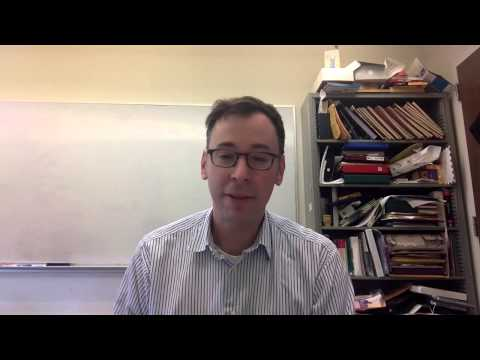

In [3]:
MoocVideo("NIhMjm7cyug", src_location="6.1-intro")

# Making  3D topological invariants out of 2D ones

Let us follow the direction explained by Joel Moore and construct a three-dimensional topological state from the two-dimensional topological state. This time, we'll do this by studying the system in momentum space rather than in real space as we did before. As with two dimensional systems, time-reversal invariant momenta (TRIMs) play an important role in three dimensions. 

For illustrative purposes, consider the three dimensional irreducible Brillouin Zone (i.e. $k_j\in [0,\pi]$) of a cubic system shown below. Fixing one of the three momenta $k_{x,y,z}$ to a TRIM, say $k_x=0$ without loss of generality, we can think of the Hamiltonian in the $(k_y,k_z)$ plane as a two dimensional Hamiltonian, which may either be topologically trivial ($\mathbb{Z}_2$-index $=0$) or non-trivial ($\mathbb{Z}_2$-index $=1$).


![](figures/3dbz.svg)

So for every side of the cube shown above we can compute a QSHE topological invariant, which gives us 6 numbers. However not all of them are independent. Specifically, there is a constraint $Q(k_x=0)\,Q(k_x=\pi) \equiv Q(k_y=0)\,Q(k_y=\pi) \equiv Q(k_z=0)\,Q(k_z=\pi)$.

This product is called *the strong topological invariant*. Accordingly, the topological insulators where this invariant is non-trivial are called strong topological insulators. For the remaining three invariants, we can choose  $Q(k_x=\pi),\,Q(k_y=\pi),\,Q(k_z=\pi)$.

Very frequently the topological invariants of a compound are written as $(1;010)$, where the first number corresponds to the strong invariant, and the remaining three to the weak invariants along each axis. For example, the first predicted topological insulator, the alloy Bi$_x$Sb$_{1-x}$ is $(1;111)$, and the second generation topological insulators Bi$_2$Te$_3$ and Bi$_2$Se$_3$ are $(1;000)$.

Just by using the bulk-edge correspondence for $Q$ we know that the strong topological invariant means that there is an odd number of helical states going in each direction on each facet of the topological insulator. We will see later why this is special, but before that let's construct a model for a 3D TI.

# BHZ model of a 3D topological insulator

Our goal in this unit is to derive an effective three-dimensional Hamiltonian $H(\mathbf{k})$ for a strong topological insulator.

We follow the same logic that led us to defining the three-dimensional topological invariant in the previous unit, building up on our knowledge of 2D topological insulators. Our first step is therefore to set $k_z=0$ and start from a two-dimensional Bloch Hamiltonian which describes a non-trivial 2D topological insulator. Of course, we choose a model we already know for this 2D Hamiltonian, the Bernevig-Hughes-Zhang (BHZ) model.

Let's recapitulate what we said about the BHZ model last week. It is a four band model, which has two electron bands (spin up and spin down) and two hole bands (spin up and down). It has inversion symmetry, with electron and hole bands having opposite parity. We will not need more bands for our 3D topological insulator model.

Copying the BHZ Hamiltonian of last week, at $k_z=0$ we have 

$$
H(k_z=0) = \epsilon(\mathbf{k})\cdot\mathbb{1} +
\begin{pmatrix}
M_0(\mathbf{k}) & A k_+ & 0 & 0 \\
A k_- & -M_0(\mathbf{k}) & 0 & 0 \\
0 & 0 & M_0(\mathbf{k}) & -Ak_- \\
0 & 0 & -Ak_+ & -M_0(\mathbf{k})
\end{pmatrix}\,,
$$

where $k_\pm = k_x \pm i k_y$. This Hamiltonian is written in a basis given by the states $\left|E\uparrow\right\rangle$, $\left|H\uparrow\right\rangle$, $\left|E\downarrow\right\rangle$, $\left|H\downarrow\right\rangle$, in that order. The block structure of the Hamiltonian reminds you that it is a doubled version of a Chern insulator, with two diagonal blocks for up and down spins. The particular form of $\epsilon(\mathbf{k})$ can be important to describe the band structure of a given material, but will not play a role in what follows. The effective mass is given by $M_0(\mathbf{k}) = M - B(k_x^2+k_y^2)$, and the transition between the topological and trivial insulating phases in this 2D model happens when $M$ changes sign.

To get a strong topological insulator, we would like the two-dimensional $\mathbb{Z}_2$ invariant applied to the $(k_x, k_y)$ plane to take different values at $k_z=0$ and $k_z=\pi$. It is easy to achieve this by adding a $k_z$-dependent term to the effective mass, for instance in the following way

$$
M_0(\mathbf{k})\,\to\,M(\mathbf{k}) = M - B(k_x^2+k_y^2+k_z^2)\,.
$$

Compared to the 2D model above, we can make the sign of the 'new' mass $M-Bk_z^2$ effectively change at fixed $k_x$ and $k_y$ by choosing $k_z$ large enough.

There is now a problem, however. Looking at the Hamiltonian at different values of $k_z$, we see that if we fix $k_z$ it still has time-reversal symmetry. Since it is topologically nontrivial at $k_z=0$ and becomes trivial at $k_z = \pi$, it should have a topological phase transition somewhere in between.

In other words, if we just add the $B k_z^2$ term, the Hamiltonian becomes gapless! Of course, we would like to have a gapped Hamiltonian in the whole 3D Brillouin zone instead.

How can we avoid the gap closing? We definitely need to couple the two spin blocks in $H(\mathbf{k})$, since otherwise each block is undergoing a Chern insulator transition. Recall that spin is odd under time-reversal, so to couple the spins we need a coupling which is odd in momentum, in order to maintain time-reversal invariance in the system. The simplest thing is to pick a coupling that is linear in $k_z$.

We then arrive at the following 3D Hamiltonian,

$$
H(\mathbf{k}) = \epsilon(\mathbf{k})\cdot\mathbb{1} +
\begin{pmatrix}
M(\mathbf{k}) & A k_+ & 0 & \tilde{A}k_z \\
A k_- & -M(\mathbf{k}) & \tilde{A}k_z & 0 \\
0 & \tilde{A}k_z & M(\mathbf{k}) & -Ak_- \\
\tilde{A}k_z & 0 & -Ak_+ & -M(\mathbf{k})
\end{pmatrix}\,.
$$

This Hamiltonian is known as the **3D BHZ model**. It is gapped at finite $M$, and a transition between the trivial and strong topological insulator phases is achieved by changing the sign of $M$. Just like its two-dimensional counterpart, the 3D BHZ model can be used as a prototype for a strong topological insulator, as well as a starting point to model real materials. 

The above derivation makes one important point evident: a necessary ingredient to have a strong topological insulator is to break spin conservation. Above, we achieved this by adding coupling between the spins, to avoid the undesirable gap closing at finite $k_z$

# Dirac surface states

What is the dispersion of the surface state of the $3D$ topological insulator?

We know that if we fix one momentum (say $k_x$) to zero, the Hamiltonian of the remaining system is that of a quantum spin Hall insulator. For this system we know that the Hamiltonian of the edge states is just that of a pair of counter-propagating modes, so

$$H = v \sigma_y k_y.$$

Here, the matrix $\sigma_y$ acts on the degrees of freedom of these two surface modes, and doesn't correspond to particle spin.

Since time-reversal symmetry changes the sign of $k_y$, it must also change the sign of $\sigma_y$, so the time-reversal operator must be $\mathcal{T} = i \sigma_y K$.

What if we consider a nonzero $k_x$? Generically, the two modes are then coupled by an extra term in the Hamiltonian. This term should be proportional to $k_x$, and since it couples the modes it must also include a Pauli matrix, which we can just choose to be $\sigma_x$.

So if the surface of the topological insulator is isotropic, its Hamiltonian is merely

$$H=v \mathbf{\sigma} \cdot \mathbf{k}.$$

Let's have a quick look at it to get a more concrete understanding:

b':HoloMap   [$M$]\n   :Overlay\n      .Surface.I  :Surface   [$k_x$,$k_y$]   ($E$)\n      .Surface.II :Surface   [$k_x$,$k_y$]   ($E$)'
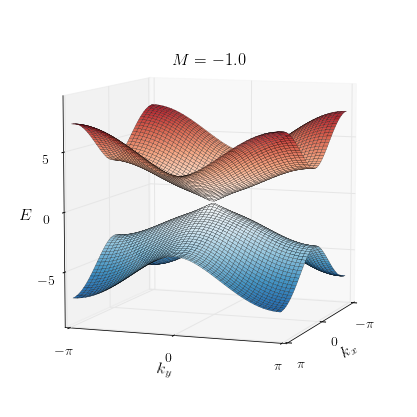
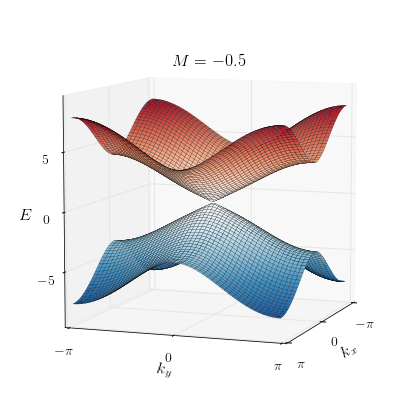
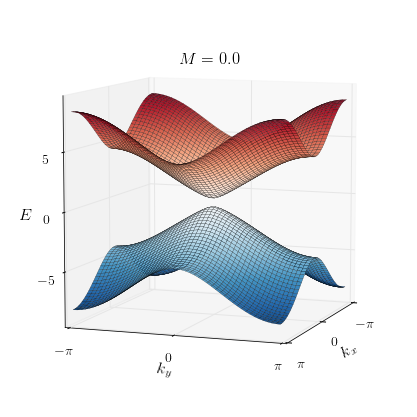
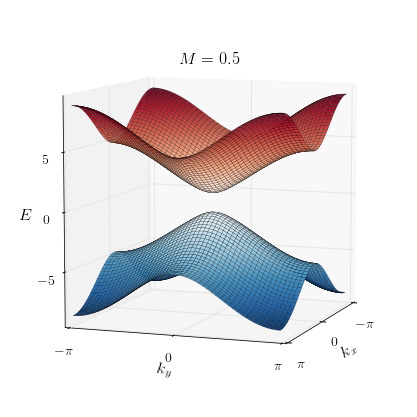
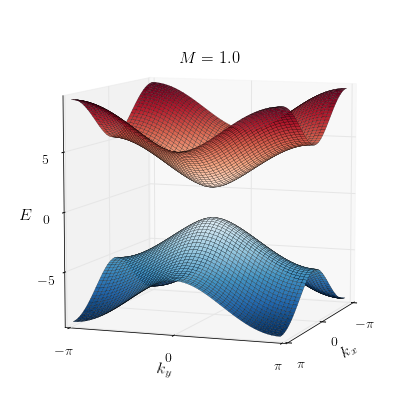

In [4]:
p = SimpleNamespace(A1=1, A2=1.5, B1=1, B2=1, C=0, D1=0, D2=0, M=None, Bz=0)
sys = bhz(Z=5, system_type='slab')
k = np.linspace(-np.pi, np.pi)
Ms = np.linspace(-1, 1, 5)
holoviews.HoloMap({p.M: spectrum(sys, p, k_x=k, k_y=k, k_z=0, title=title, num_bands=2) for p.M in Ms}, kdims=[r'$M$'])

What you see here is the dispersion of the two lowest energy bands of a thin slice of a 3D BHZ model.

The system is topological when $M<0$. As expected, the lowest energy state then has a Dirac dispersion, and surface states are formed.

The distinguishing feature of the strong topological insulator is that it has an odd number of Dirac cones in total.
In fact, the reason why it is called "strong" is also the reason why an odd number of Dirac cones is special.

To see what is unique, let us add an infinitesimal magnetic field and compute the Chern number of the surface state. We know that the number of Dirac cones is odd. From our study of Chern insulators, we know that the *change* in the Chern number between $B = -\varepsilon$ and $B = +\varepsilon$ is just the number of the Dirac cones. This is because we open a gap at each of them.

Since the Chern number is odd under time reversal, we come to a paradoxical conclusion: if we break time reversal, we end up with a half-integer Hall conductance $\sigma_{xy} = e^2/h (n + 1/2)$ on a surface of a topological insulator.

This is of course not possible in any purely 2D system, since the Hall conductance must be an integer, and therefore the surface state of a strong topological insulator cannot be created without the topological bulk.

> The statement that it is impossible to have a tight-binding Hamiltonian with time-reversal symmetry and a single Dirac cone is known as the "fermion doubling theorem". There are several tricks that one can perform to work around this limitation in a numerical simulation, but we won't cover them in the course.

# Weak invariants

Now that we understand what is special about the strong invariant, let's deal with the weak invariants.

From their definition, we know that the weak invariants don't change the parity of the number of Dirac cones on any surface.
Furthermore, there is a very good reason why the weak invariants are called 'weak'. Imagine we keep the Hamiltonian the same, but instead we double the unit cell in each direction. This folds the Brillouin zone onto itself such that $k=\pi$ is mapped to $k=0$. This doesn't impact the strong invariant, but all the weak invariants become 0.

As a final illustration of the relation between weak and strong invariants, let's see how the invariants change as a function of $M$ as we vary $M$ on a scale comparable with the band width.

We determine the topological invariant in the same way as for QSHE: we see if the phase of the reflection matrix connects the Pfaffians of $r(k_y=0)$ and $r(k_y=\pi)$.

:Layout
   .HoloMap.M_equals_hyphen_minus_2_full_stop_75 :HoloMap   [$M$]
      :Overlay
         .Surface.I  :Surface   [$k_x$,$k_y$]   ($E$)
         .Surface.II :Surface   [$k_x$,$k_y$]   ($E$)
   .HoloMap.I                                    :HoloMap   [$M$]
      :Overlay
         .Path.K_x_equals_0               :Path   [$k_y$,phase]
         .Points.I                        :Points   [$k_y$,phase]
         .Path.K_x_equals_reverse_over_pi :Path   [$k_y$,phase]
         .Points.II                       :Points   [$k_y$,phase]
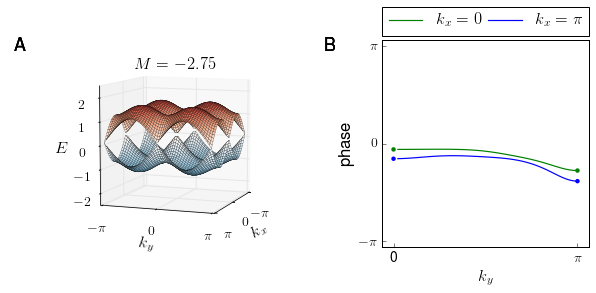
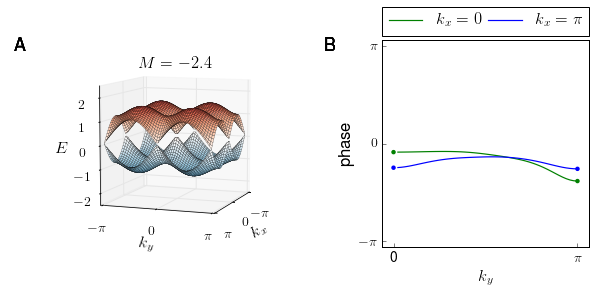
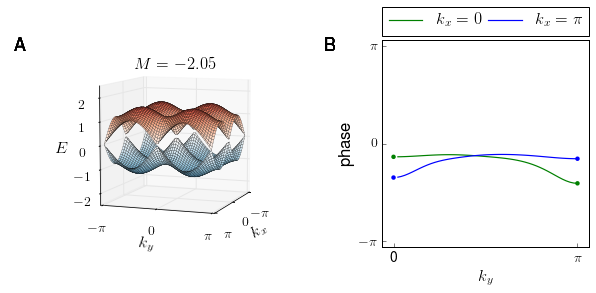
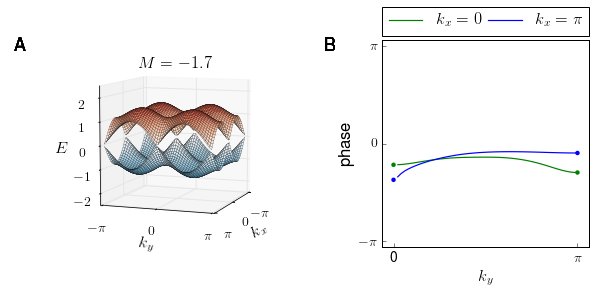
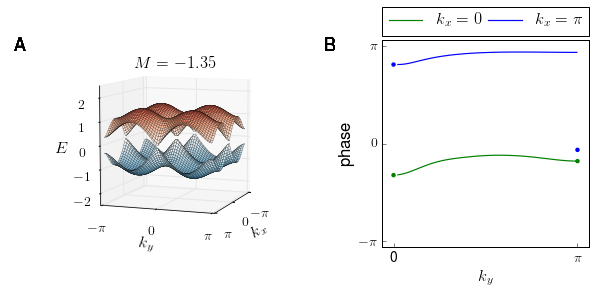
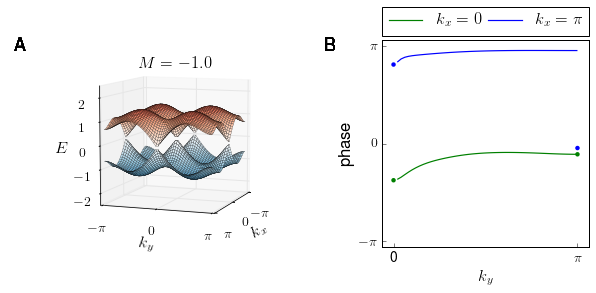
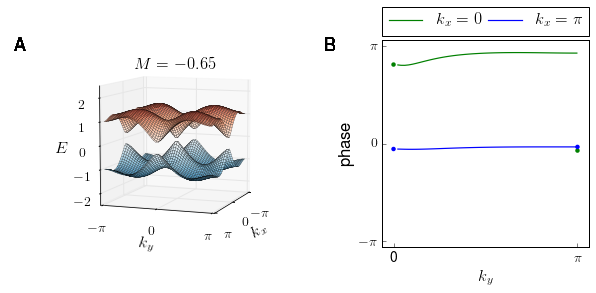
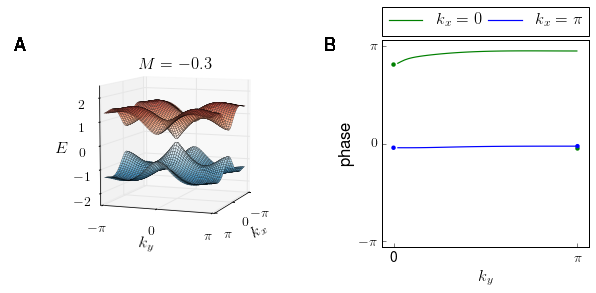
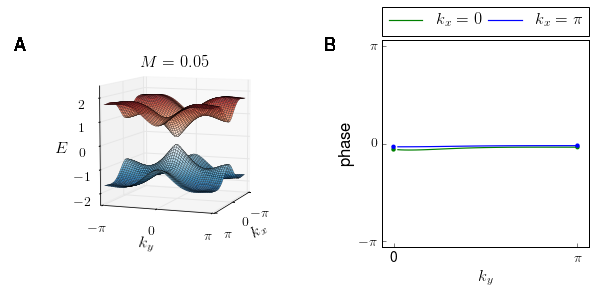
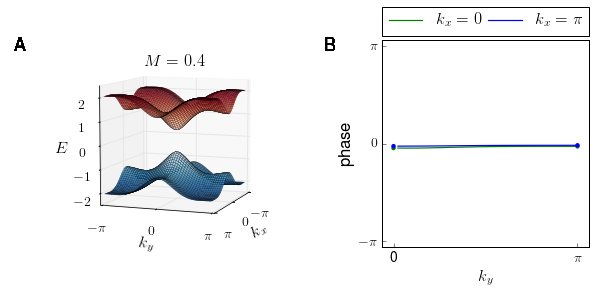
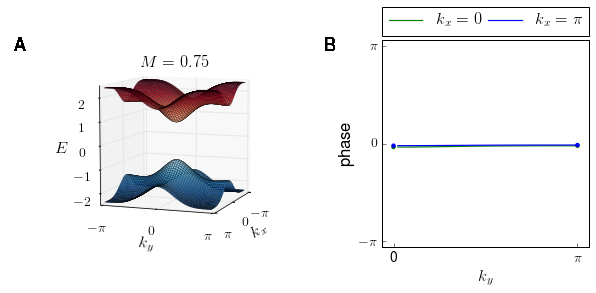

In [5]:
p = SimpleNamespace(A1=1, A2=1, B1=1, B2=0.2, C=0, D1=0.1, D2=0, M=None, Bz=0)
sys = bhz(Z=15, system_type='slab')
fsys = make_scatter_sys()
k = np.linspace(-np.pi, np.pi)
Ms = np.linspace(-2.75, 0.75, 11)
hm1 = holoviews.HoloMap({p.M: spectrum(sys, p, k_x=k, k_y=k, k_z=0, title=title, num_bands=2) 
                         for p.M in Ms}, kdims=[r'$M$'])
hm2 = holoviews.HoloMap({p.M: scattering_det_pfaff(fsys, p) for p.M in Ms}, kdims=[r'$M$'])
hm1 + hm2

We see the values of the invariants change several times:

* Initially, when $M>0$, the system is trivial.
* Then, as $M$ is lowered, the topological invariants become $\mathcal{Q}(k_x=0) = 1$ and $\mathcal{Q}(k_x=\pi) = 0$, and there's a Dirac cone at $k=0$.
* When $M$ is lowered further, two new Dirac cones appear at $k = (0,\pi)$ and $k = (\pi, 0)$. This changes the invariants to $\mathcal{Q}(k_x=0) = 0$ and $\mathcal{Q}(k_x=\pi) = 1$.
* Finally one more Dirac cone appears at $k = (\pi, \pi)$, accompanied by both invariants becoming trivial.

In [6]:
question = ("Suppose you have a $(0;100)$ weak topological insulator. Which one of the following statements is correct?")

answers = ["There is an even number of Dirac cones for both $k_x=0$ and $k_x=\pi$.",
           "There is an even number of Dirac cones for $k_x=0$ and an odd one for $k_x=\pi$.",
           "There is an odd number of Dirac cones for $k_x=0$ and an even one for $k_x=\pi$.",
           "There is an odd number of Dirac cones for both $k_x=0$ and $k_x=\pi$."]

explanation = ("We know that the strong invariant $Q(k_x=0)Q(k_x=\pi)=0$, so there must be an even number of Dirac cones in total. "
               "The number at $k_x=\pi$ is odd because $Q(k_x=\pi)=1$, so the number at $k_x=0$ must also be odd.")

MoocMultipleChoiceAssessment(question=question, answers=answers, correct_answer=3, explanation=explanation)

MoocMultipleChoiceAssessment(**{'explanation': 'We know that the strong invariant $Q(k_x=0)Q(k_x=\\pi)=0$, so there must be an even number of Dirac cones in total. The number at $k_x=\\pi$ is odd because $Q(k_x=\\pi)=1$, so the number at $k_x=0$ must also be odd.', 'answers': ['There is an even number of Dirac cones for both $k_x=0$ and $k_x=\\pi$.', 'There is an even number of Dirac cones for $k_x=0$ and an odd one for $k_x=\\pi$.', 'There is an odd number of Dirac cones for $k_x=0$ and an even one for $k_x=\\pi$.', 'There is an odd number of Dirac cones for both $k_x=0$ and $k_x=\\pi$.'], 'correct_answer': 3, 'question': 'Suppose you have a $(0;100)$ weak topological insulator. Which one of the following statements is correct?', 'max_attempts': 2, 'display_name': 'Question'})

# Quantum Hall conductance and the magneto-electric effect

So, what happens if we measure the Hall conductance of a 3D topological insulator? Will we actually obtain a half-integer? If you followed the course closely, you will know that the answer is negative, and that the Hall conductance is always quantized to an integer. So what is going on when we measure the Hall conductance?

To answer this question we need to remember that we cannot just consider one surface on its own. Each surface is connected to the sides and other surfaces. Let's consider a part of a 3D TI in magnetic field:

![](figures/3d_ti_slab.svg)

The top surface has the quantum Hall conductance $(n + 1/2)e^2/h$, but it is not the only part of the material. The bottom surface is also subject to a magnetic field and hence contributes a half-integer Hall conductance as well.

In total we thus get $\sigma_{xy} = (2n + 1) e^2/h$: an integer, which resolves the apparent paradox. While this statement sounds relatively simple, there are entire papers dedicated to the question whether it's possible to measure a half-integer Hall conductance (the answer is 'not really').

Finally, let's look at the dispersion of the Landau levels and edge states:

b':Path   [$k_x$,$E$]'
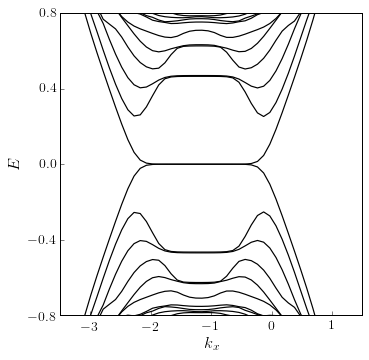

In [7]:
%%output size=150
p = SimpleNamespace(A1=1, A2=1, B1=1, B2=1, C=0, D1=0, D2=0, M=-1, Bz=0.125)
lead = bhz(Y=20, Z=10, system_type='lead')
k = np.linspace(-3.5, 1.5)
kwargs = {'ylims': [-0.8, 0.8],
          'yticks': 5}
spectrum(lead, p, k_x=k, **kwargs)

We see that the Landau levels come in pairs. In each such pair, one level comes from the top surface, and one from the bottom surface. The magnetic field is parallel to the side surfaces, so there is no gap there. The edge states propagate freely along the side surfaces and are reflected by the magnetic field as they try to enter either the top or the bottom surfaces.

In [8]:
question = ("Suppose that you take the 3D TI slab above, and connect the left and right surfaces, making it into "
            "a very thick Corbino disk. "
            "You then apply to it a strong perpendicular field in the same direction as in the figure, perpendicular to the top "
            "and bottom surfaces. "
            "What happens if you throw an additional flux quantum through the inner hole of the disk?")

answers = ["A half-integer number of electron charges is transferred from the inner to the outer surface of the disk.",
           "An integer number of electron charges is transferred from the inner to the outer surface of the disk.",
           "An integer number of charges is transferred from the top to the bottom surface of the disk.",
           "The bulk gap closes."]

explanation = ("The top and bottom surfaces combined form an integer quantum Hall state. "
               "Hence the whole system acts like a Laughlin pump, exactly like in the purely 2D case.")

MoocMultipleChoiceAssessment(question=question, answers=answers, correct_answer=1, explanation=explanation)

MoocMultipleChoiceAssessment(**{'explanation': 'The top and bottom surfaces combined form an integer quantum Hall state. Hence the whole system acts like a Laughlin pump, exactly like in the purely 2D case.', 'answers': ['A half-integer number of electron charges is transferred from the inner to the outer surface of the disk.', 'An integer number of electron charges is transferred from the inner to the outer surface of the disk.', 'An integer number of charges is transferred from the top to the bottom surface of the disk.', 'The bulk gap closes.'], 'correct_answer': 1, 'question': 'Suppose that you take the 3D TI slab above, and connect the left and right surfaces, making it into a very thick Corbino disk. You then apply to it a strong perpendicular field in the same direction as in the figure, perpendicular to the top and bottom surfaces. What happens if you throw an additional flux quantum through the inner hole of the disk?', 'max_attempts': 2, 'display_name': 'Question'})

# Conclusion: integers, half-integers, and two types of electromagnetic response

Before we move on to the next lecture, Joel Moore will tell us more about the origins of the peculiar electromagnetic response of topological insulators, and a fascinating connection to high energy physics.

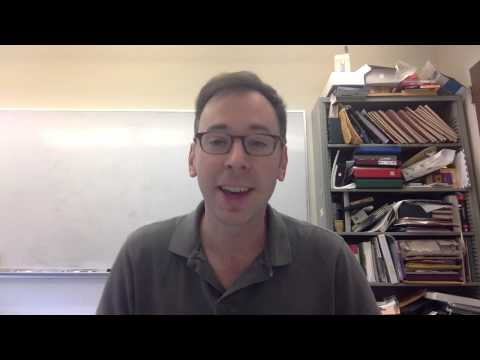

In [9]:
MoocVideo("s7H6oLighOM", src_location="6.1-summary")

In [10]:
MoocDiscussion("Questions", "3DTI invariants")

MoocDiscussion(**{'discussion_target': '3DTI invariants', 'discussion_category': 'Questions', 'discussion_id': 'd3468640988adb6b6a4bcefa82a5ce50', 'display_name': '3DTI invariants'})